# Question 2: Classification
## Machine Learning Foundations with Python 
### 90-803 - Spring 2024
### Sprint Team #17
### Name:  Jewel Yoko Kentilitisca, Hannah Ngyugen, Quintessa Guegerich


### Can we predict the impact of rising temperatures on changes in property prices in areas designated as "climate ready"?
Reference for "climate ready" states: (https://www.architecturaldigest.com/reviews/solar/most-climate-resilient-cities)

   Target variable: The target variable for this classification problem is the direction of the impact of rising temperatures on property prices in a given area. It is represented as a categorical variable with three levels:

    (a) 3 - Positive impact: Rising temperatures lead to a significant increase in property prices 
    (b) 2 - Medium impact: Rising temperatures lead to a moderate increase in property prices
    (c) 1 - Negative impact: Rising temperatures lead to a decrease in property prices


### Ideas 
   (a) Generate a heatmap to visualize the correlation matrix between temperature anomalies and other variables, including housing price changes. 

In [1]:
# importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import geopandas as gpd

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split, LeaveOneOut, KFold, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV 
from sklearn.preprocessing import OneHotEncoder
import time

from yellowbrick.target import ClassBalance
from imblearn.over_sampling import SMOTE

# Importing preprocessing and modeling libraries
from sklearn import preprocessing
from sklearn import neighbors
from sklearn import tree

# Importing metrics for model evaluation
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.metrics import recall_score, precision_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn import metrics

# Importing class balance tools for handling imbalanced datasets
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from yellowbrick.target import ClassBalance

# Importing classifier models
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

### Preprocessing the Data

In [2]:
#Dictionary for state codes for us to be able to merge another dataset for longitude and latitude
state_codes = {
    'AL': '01',
    'AK': '02',
    'AZ': '04',
    'AR': '05',
    'CA': '06',
    'CO': '08',
    'CT': '09',
    'DE': '10',
    'FL': '12',
    'GA': '13',
    'HI': '15',
    'ID': '16',
    'IL': '17',
    'IN': '18',
    'IA': '19',
    'KS': '20',
    'KY': '21',
    'LA': '22',
    'ME': '23',
    'MD': '24',
    'MA': '25',
    'MI': '26',
    'MN': '27',
    'MS': '28',
    'MO': '29',
    'MT': '30',
    'NE': '31',
    'NV': '32',
    'NH': '33',
    'NJ': '34',
    'NM': '35',
    'NY': '36',
    'NC': '37',
    'ND': '38',
    'OH': '39',
    'OK': '40',
    'OR': '41',
    'PA': '42',
    'RI': '44',
    'SC': '45',
    'SD': '46',
    'TN': '47',
    'TX': '48',
    'UT': '49',
    'VT': '50',
    'VA': '51',
    'WA': '53',
    'WV': '54',
    'WI': '55',
    'WY': '56'
}


In [3]:
#Reading the CSVs
merged_data = pd.read_csv('all_data.csv')
merged_data.head()
merged_data['StateFP'] = merged_data['StateAbbrv'].map(state_codes)
us_counties = gpd.read_file('tl_2022_us_county/tl_2022_us_county.shp')

merged_data = merged_data.merge(us_counties, left_on=['RegionName', 'StateFP'], right_on=['NAMELSAD', 'STATEFP'])

merged_data.head()

#Keeping these columns and converting to float
columns_to_float = ['ALAND', 'AWATER', 'INTPTLAT', 'INTPTLON']
merged_data[columns_to_float] = merged_data[columns_to_float].astype(float)

#Filtering for states we wanna deep dive in
filtered_states = merged_data[merged_data['State'].isin(['CO', 'NY', 'CA', "FL", 'IL', 'PA', 'NC', 'TX', 'WA', "NM", "UT"])]


### Figuring out how to make this into a classification problem

1. Make temperature into a multiclass of 1 = Low, 2 = Medium, and 3 - High in terms of temperature risk based on anomalies [did not go with this option]
2. Look at the ratio changes between purchase price, bottom tier average home value estimate, and top tier average home value estimate, grouping by month/year.
3. Include temperature anomaly data into one combined value reflecting the impact on housing prices, trying to calculate by putting weights?

    -Normalizing the Temperature Anomaly Data: Ensure that the temperature anomaly data is on a similar scale as the housing price data. This might involve scaling or normalization.

    -Define Weights: Assign weights to the housing price change and temperature anomaly change based on their relative importance in influencing housing prices. These weights can be subjective.

    -Calculate Combined Impact: Multiply the percentage change in housing prices and the normalized temperature anomaly data by their respective weights, and then add them together to get a combined impact value.

### Intention: Look if positive values may indicate that higher temperature anomalies are associated with a higher likelihood of a certain class (higher percentage change in housing prices, both for bottom tier and top tier), while negative values may indicate the opposite.

### The idea was to make a ratio change/ percentage change of each year of bottom tier home value prices, top tier home value prices, and purchase price 

In [4]:
# Group the data by 'County Name' and calculate the percentage change for each group
filtered_states['Pct_Change_Bottom_Tier'] = filtered_states.groupby(['RegionName', 'State', 'Month', 'Term to Maturity'])['Bottom-Tier Average Home Value Estimate'].pct_change()*100
filtered_states['Pct_Change_Top_Tier'] = filtered_states.groupby(['RegionName', 'State', 'Month', 'Term to Maturity'])['Top-Tier Average Home Value Estimate'].pct_change()*100
filtered_states['Pct_Change'] = filtered_states.groupby(['RegionName', 'State', 'Month', 'Term to Maturity'])['Purchase Price ($thou)'].pct_change()*100

#Creating a new column for the ratio change of 'Bottom_Tier', 'Top_Tier', and 'Pct_Change'
filtered_states['Ratio_Change_Bottom_Tier'] = filtered_states['Pct_Change_Bottom_Tier'] / filtered_states['Anomaly (1901-2000 base period)']
filtered_states['Ratio_Change_Top_Tier'] = filtered_states['Pct_Change_Top_Tier'] / filtered_states['Anomaly (1901-2000 base period)']
filtered_states['Ratio_Change_Purchase_Price_Tier'] = filtered_states['Pct_Change'] / filtered_states['Anomaly (1901-2000 base period)']

filtered_states.head()


/var/folders/6c/t8_sl0r155q97klcrfwnkw7h0000gn/T/ipykernel_18984/3250632008.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_states['Pct_Change_Bottom_Tier'] = filtered_states.groupby(['RegionName', 'State', 'Month', 'Term to Maturity'])['Bottom-Tier Average Home Value Estimate'].pct_change()*100
/var/folders/6c/t8_sl0r155q97klcrfwnkw7h0000gn/T/ipykernel_18984/3250632008.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_states['Pct_Change_Top_Tier'] = filtered_states.groupby(['RegionN

,Unnamed: 0,Date,Year,Month,RegionName,State,Bottom-Tier Average Home Value Estimate,Top-Tier Average Home Value Estimate,Value,Anomaly (1901-2000 base period),...,AWATER,INTPTLAT,INTPTLON,geometry,Pct_Change_Bottom_Tier,Pct_Change_Top_Tier,Pct_Change,Ratio_Change_Bottom_Tier,Ratio_Change_Top_Tier,Ratio_Change_Purchase_Price_Tier
0,0,2000-01-31,2000,1,Los Angeles County,CA,122826.545216,400192.738911,52.3,4.5,...,1.785003e+09,34.196398,-118.261862,"MULTIPOLYGON (((-118.67820 33.03973, -118.6756...",NaN,NaN,NaN,NaN,NaN,NaN
1,1,2000-01-31,2000,1,Los Angeles County,CA,122826.545216,400192.738911,52.3,4.5,...,1.785003e+09,34.196398,-118.261862,"MULTIPOLYGON (((-118.67820 33.03973, -118.6756...",NaN,NaN,NaN,NaN,NaN,NaN
2,1566,2000-02-29,2000,2,Los Angeles County,CA,122977.776411,400660.415894,50.6,1.1,...,1.785003e+09,34.196398,-118.261862,"MULTIPOLYGON (((-118.67820 33.03973, -118.6756...",NaN,NaN,NaN,NaN,NaN,NaN
3,1567,2000-02-29,2000,2,Los Angeles County,CA,122977.776411,400660.415894,50.6,1.1,...,1.785003e+09,34.196398,-118.261862,"MULTIPOLYGON (((-118.67820 33.03973, -118.6756...",NaN,NaN,NaN,NaN,NaN,NaN
4,3136,2000-03-31,2000,3,Los Angeles County,CA,123487.708531,402315.707957,53.8,1.7,...,1.785003e+09,34.196398,-118.261862,"MULTIPOLYGON (((-118.67820 33.03973, -118.6756...",NaN,NaN,NaN,NaN,NaN,NaN


### Cleaning the Data
(a) Since there we did a percentage change on Purchase Price, Bottom Tier Average Home Value Estimate and Top Tier Average Home Value Estimate, there will be Nans on the first year (all of 2000). THe number of null values is consistent with the number of counties * 2 (because we have 2 values per date for 15 year and 30 year loan).

In [5]:
#Looking at null values since we did a percentange change and will most likely have Nans
pd.concat({"Number missing values":filtered_states.isnull().sum()
            , "Percentage of missing values":filtered_states.isnull().sum()*100/filtered_states.shape[0]}
            , axis=1)

,Number missing values,Percentage of missing values
Unnamed: 0,0,0.000000
Date,0,0.000000
Year,0,0.000000
Month,0,0.000000
RegionName,0,0.000000
State,0,0.000000
Bottom-Tier Average Home Value Estimate,0,0.000000
Top-Tier Average Home Value Estimate,0,0.000000
Value,0,0.000000
Anomaly (1901-2000 base period),0,0.000000


(b) Dropping Nans

In [6]:
columns_to_drop_nans = ['Pct_Change_Bottom_Tier', 'Pct_Change_Top_Tier', 'Pct_Change', 'Ratio_Change_Bottom_Tier', 'Ratio_Change_Top_Tier', 'Ratio_Change_Purchase_Price_Tier']
filtered_states.dropna(subset=columns_to_drop_nans, inplace=True)

/var/folders/6c/t8_sl0r155q97klcrfwnkw7h0000gn/T/ipykernel_18984/3976575983.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_states.dropna(subset=columns_to_drop_nans, inplace=True)


In [7]:
#Checking Again
#Looking at null values since we did a percentange change and will most likely have Nans
pd.concat({"Number missing values":filtered_states.isnull().sum()
            , "Percentage of missing values":filtered_states.isnull().sum()*100/filtered_states.shape[0]}
            , axis=1)

,Number missing values,Percentage of missing values
Unnamed: 0,0,0.0
Date,0,0.0
Year,0,0.0
Month,0,0.0
RegionName,0,0.0
State,0,0.0
Bottom-Tier Average Home Value Estimate,0,0.0
Top-Tier Average Home Value Estimate,0,0.0
Value,0,0.0
Anomaly (1901-2000 base period),0,0.0


#### Before dropping any columns, lets look at the spread 

In [8]:
#Looking at who has the highest ratio change for purchase price
top_ratio_changes = filtered_states.sort_values(by='Ratio_Change_Top_Tier', ascending=False)
top_ratio_changes.head()

,Unnamed: 0,Date,Year,Month,RegionName,State,Bottom-Tier Average Home Value Estimate,Top-Tier Average Home Value Estimate,Value,Anomaly (1901-2000 base period),...,AWATER,INTPTLAT,INTPTLON,geometry,Pct_Change_Bottom_Tier,Pct_Change_Top_Tier,Pct_Change,Ratio_Change_Bottom_Tier,Ratio_Change_Top_Tier,Ratio_Change_Purchase_Price_Tier
110607,323471,2012-08-31,2012,8,Cabarrus County,NC,84540.402777,247318.478691,76.9,-0.0,...,6985702.0,35.388345,-80.552728,"POLYGON ((-80.57060 35.50332, -80.56958 35.503...",-3.110860,-2.295111,14.200426,inf,inf,-inf
120655,133015,2006-05-31,2006,5,Charlotte County,FL,115615.779810,402540.698326,76.7,0.0,...,689242502.0,26.906396,-82.003657,"POLYGON ((-82.25533 27.00559, -82.25531 27.005...",24.750217,20.662289,7.092820,inf,inf,inf
311113,261689,2010-11-30,2010,11,Routt County,CO,182716.541504,870755.250075,27.6,-0.0,...,15831744.0,40.483664,-106.987702,"POLYGON ((-106.65274 40.38897, -106.65274 40.3...",-2.613714,-2.829218,2.668823,inf,inf,-inf
311112,261688,2010-11-30,2010,11,Routt County,CO,182716.541504,870755.250075,27.6,-0.0,...,15831744.0,40.483664,-106.987702,"POLYGON ((-106.65274 40.38897, -106.65274 40.3...",-2.613714,-2.829218,-33.531746,inf,inf,inf
144128,26234,2001-05-31,2001,5,Randolph County,NC,70800.838538,186962.996903,67.1,0.0,...,19757513.0,35.709915,-79.806215,"POLYGON ((-79.59030 35.51449, -79.59044 35.514...",6.633962,5.102391,14.669653,inf,inf,inf


In [9]:
bottom_ratio_changes = filtered_states.sort_values(by='Ratio_Change_Bottom_Tier', ascending=False)
bottom_ratio_changes.head()

,Unnamed: 0,Date,Year,Month,RegionName,State,Bottom-Tier Average Home Value Estimate,Top-Tier Average Home Value Estimate,Value,Anomaly (1901-2000 base period),...,AWATER,INTPTLAT,INTPTLON,geometry,Pct_Change_Bottom_Tier,Pct_Change_Top_Tier,Pct_Change,Ratio_Change_Bottom_Tier,Ratio_Change_Top_Tier,Ratio_Change_Purchase_Price_Tier
174168,61872,2003-02-28,2003,2,Craven County,NC,65196.559347,186498.750067,45.0,0.0,...,172777673.0,35.116829,-77.081320,"POLYGON ((-77.35235 35.32790, -77.35213 35.328...",3.291708,3.000624,11.069767,inf,inf,inf
490664,250192,2010-07-31,2010,7,Lincoln County,NM,126287.301696,383209.698430,71.7,-0.0,...,554839.0,33.740841,-105.449805,"POLYGON ((-105.92597 34.25999, -105.92460 34.2...",-1.511200,-2.272927,-4.149026,inf,inf,inf
532666,371084,2013-10-31,2013,10,Robertson County,TX,62643.952190,275045.910199,68.2,0.0,...,27332985.0,31.025481,-96.514941,"POLYGON ((-96.83110 31.10234, -96.83085 31.102...",2.610895,4.921119,-10.938066,inf,inf,-inf
532667,371085,2013-10-31,2013,10,Robertson County,TX,62643.952190,275045.910199,68.2,0.0,...,27332985.0,31.025481,-96.514941,"POLYGON ((-96.83110 31.10234, -96.83085 31.102...",2.610895,4.921119,-0.567322,inf,inf,-inf
258776,518062,2017-06-30,2017,6,Stokes County,NC,77479.452978,226901.993280,72.4,0.0,...,17578801.0,36.393797,-80.269921,"POLYGON ((-80.44467 36.47552, -80.44386 36.487...",4.800633,3.498520,6.890812,inf,inf,inf


In [10]:
pp_price_ratio_changes = filtered_states.sort_values(by='Ratio_Change_Purchase_Price_Tier', ascending=False)
pp_price_ratio_changes.head()

,Unnamed: 0,Date,Year,Month,RegionName,State,Bottom-Tier Average Home Value Estimate,Top-Tier Average Home Value Estimate,Value,Anomaly (1901-2000 base period),...,AWATER,INTPTLAT,INTPTLON,geometry,Pct_Change_Bottom_Tier,Pct_Change_Top_Tier,Pct_Change,Ratio_Change_Bottom_Tier,Ratio_Change_Top_Tier,Ratio_Change_Purchase_Price_Tier
111420,168876,2007-11-30,2007,11,Clay County,FL,130658.168476,309589.928352,61.8,0.0,...,100869769.0,29.986583,-81.865036,"POLYGON ((-81.79723 29.83665, -81.79878 29.836...",-0.290165,-1.503167,7.898659,-inf,-inf,inf
267416,350724,2013-04-30,2013,4,Montrose County,CO,110982.578312,302832.077647,43.8,0.0,...,4923260.0,38.407507,-108.266282,"POLYGON ((-108.08669 38.27575, -108.08683 38.2...",4.785533,3.999632,5.352330,inf,inf,inf
441327,565959,2018-08-31,2018,8,Henderson County,NC,170405.179297,397988.643431,71.0,0.0,...,5531389.0,35.336415,-82.479741,"POLYGON ((-82.54338 35.42319, -82.54118 35.423...",8.697175,5.493946,5.254121,inf,inf,inf
368725,177657,2008-03-31,2008,3,Caldwell County,NC,52712.322669,190191.609703,47.2,-0.0,...,7052759.0,35.966396,-81.512540,"POLYGON ((-81.33647 36.01063, -81.33621 36.010...",1.169370,1.775248,-3.389138,-inf,-inf,inf
423901,485939,2016-09-30,2016,9,Island County,WA,226747.639851,521052.346975,57.6,0.0,...,799920796.0,48.158554,-122.670649,"POLYGON ((-122.86308 48.37036, -122.86287 48.3...",15.280781,10.025879,0.430108,inf,inf,inf


Having infinity in my dataset because we are dividing by 0's, will fix by XXX

In [11]:
# Create a boolean mask to identify infinite values

# Filter out non-numeric columns
numeric_columns = filtered_states.select_dtypes(include=np.number)

inf_values_count = np.isinf(numeric_columns).sum()
inf_values_percentage = (np.isinf(numeric_columns).sum() * 100) / filtered_states.shape[0]

# Concatenate the two Series into a DataFrame
inf_values_df = pd.concat({"Number of infinite values": inf_values_count,
                           "Percentage of infinite values": inf_values_percentage}, axis=1)

inf_values_df

,Number of infinite values,Percentage of infinite values
Unnamed: 0,0,0.000000
Year,0,0.000000
Month,0,0.000000
Bottom-Tier Average Home Value Estimate,0,0.000000
Top-Tier Average Home Value Estimate,0,0.000000
Value,0,0.000000
Anomaly (1901-2000 base period),0,0.000000
1901-2000 Mean,0,0.000000
Initial Fees and Charges (%),0,0.000000
Effective Rate (%),0,0.000000


In [12]:
filtered_states['Ratio_Change_Bottom_Tier'].replace([np.inf, -np.inf], 0, inplace=True)
filtered_states['Ratio_Change_Top_Tier'].replace([np.inf, -np.inf], 0, inplace=True)
filtered_states['Ratio_Change_Purchase_Price_Tier'].replace([np.inf, -np.inf], 0, inplace=True)

/var/folders/6c/t8_sl0r155q97klcrfwnkw7h0000gn/T/ipykernel_18984/2120886852.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_states['Ratio_Change_Bottom_Tier'].replace([np.inf, -np.inf], 0, inplace=True)
/var/folders/6c/t8_sl0r155q97klcrfwnkw7h0000gn/T/ipykernel_18984/2120886852.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_states['Ratio_Change_Top_Tier'].replace([np.inf, -np.inf], 0, inplace=True)
/var/folders/6c/t8_sl0r155q97klcrfwnkw7h0000gn/T/ipykernel_18984/2120886852.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the 

In [13]:
filtered_states.head(30)

,Unnamed: 0,Date,Year,Month,RegionName,State,Bottom-Tier Average Home Value Estimate,Top-Tier Average Home Value Estimate,Value,Anomaly (1901-2000 base period),...,AWATER,INTPTLAT,INTPTLON,geometry,Pct_Change_Bottom_Tier,Pct_Change_Top_Tier,Pct_Change,Ratio_Change_Bottom_Tier,Ratio_Change_Top_Tier,Ratio_Change_Purchase_Price_Tier
24,19022,2001-01-31,2001,1,Los Angeles County,CA,134011.292609,434953.121289,47.3,-0.5,...,1.785003e+09,34.196398,-118.261862,"MULTIPOLYGON (((-118.67820 33.03973, -118.6756...",9.106132,8.685910,8.582949,-18.212264,-17.371821,-17.165899
25,19023,2001-01-31,2001,1,Los Angeles County,CA,134011.292609,434953.121289,47.3,-0.5,...,1.785003e+09,34.196398,-118.261862,"MULTIPOLYGON (((-118.67820 33.03973, -118.6756...",9.106132,8.685910,13.009592,-18.212264,-17.371821,-26.019185
26,20648,2001-02-28,2001,2,Los Angeles County,CA,134495.031712,436357.668087,47.1,-2.4,...,1.785003e+09,34.196398,-118.261862,"MULTIPOLYGON (((-118.67820 33.03973, -118.6756...",9.365314,8.909603,14.988426,-3.902214,-3.712335,-6.245177
27,20649,2001-02-28,2001,2,Los Angeles County,CA,134495.031712,436357.668087,47.1,-2.4,...,1.785003e+09,34.196398,-118.261862,"MULTIPOLYGON (((-118.67820 33.03973, -118.6756...",9.365314,8.909603,17.348809,-3.902214,-3.712335,-7.228670
28,22276,2001-03-31,2001,3,Los Angeles County,CA,135191.995137,438477.032394,55.4,3.3,...,1.785003e+09,34.196398,-118.261862,"MULTIPOLYGON (((-118.67820 33.03973, -118.6756...",9.478098,8.988295,17.015263,2.872151,2.723726,5.156140
29,22277,2001-03-31,2001,3,Los Angeles County,CA,135191.995137,438477.032394,55.4,3.3,...,1.785003e+09,34.196398,-118.261862,"MULTIPOLYGON (((-118.67820 33.03973, -118.6756...",9.478098,8.988295,16.967509,2.872151,2.723726,5.141669
30,23908,2001-04-30,2001,4,Los Angeles County,CA,136417.007632,442386.841903,54.8,-1.3,...,1.785003e+09,34.196398,-118.261862,"MULTIPOLYGON (((-118.67820 33.03973, -118.6756...",9.566772,9.058972,14.220705,-7.359055,-6.968440,-10.939004
31,23909,2001-04-30,2001,4,Los Angeles County,CA,136417.007632,442386.841903,54.8,-1.3,...,1.785003e+09,34.196398,-118.261862,"MULTIPOLYGON (((-118.67820 33.03973, -118.6756...",9.566772,9.058972,20.933088,-7.359055,-6.968440,-16.102375
32,25548,2001-05-31,2001,5,Los Angeles County,CA,137783.455864,446630.366990,68.5,7.2,...,1.785003e+09,34.196398,-118.261862,"MULTIPOLYGON (((-118.67820 33.03973, -118.6756...",9.531393,8.983151,14.669653,1.323805,1.247660,2.037452
33,25549,2001-05-31,2001,5,Los Angeles County,CA,137783.455864,446630.366990,68.5,7.2,...,1.785003e+09,34.196398,-118.261862,"MULTIPOLYGON (((-118.67820 33.03973, -118.6756...",9.531393,8.983151,21.678744,1.323805,1.247660,3.010937


#### Looking at the spread of the Ratio Changes


#### Ratio_Change_Bottom_Tier

(array([8.00000e+00, 2.00000e+00, 2.00000e+00, 2.00000e+00, 6.00000e+00,
        8.00000e+00, 8.00000e+00, 8.00000e+00, 2.00000e+01, 1.80000e+01,
        3.40000e+01, 3.00000e+01, 7.00000e+01, 7.60000e+01, 1.44000e+02,
        2.22000e+02, 2.86000e+02, 4.56000e+02, 9.84000e+02, 2.00600e+03,
        8.08200e+03, 1.36459e+05, 1.92840e+04, 3.08200e+03, 1.11000e+03,
        6.44000e+02, 3.58000e+02, 2.40000e+02, 1.36000e+02, 1.30000e+02,
        9.00000e+01, 3.40000e+01, 3.60000e+01, 2.20000e+01, 2.00000e+01,
        1.80000e+01, 1.60000e+01, 4.00000e+00, 6.00000e+00, 6.00000e+00,
        6.00000e+00, 4.00000e+00, 2.00000e+00, 2.00000e+00, 2.00000e+00,
        6.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 2.00000e+00]),
 array([-360.20868917, -343.55072882, -326.89276847, -310.23480812,
        -293.57684777, -276.91888742, -260.26092707, -243.60296672,
        -226.94500637, -210.28704602, -193.62908567, -176.97112532,
        -160.31316497, -143.65520462, -126.99724427, -110.339283

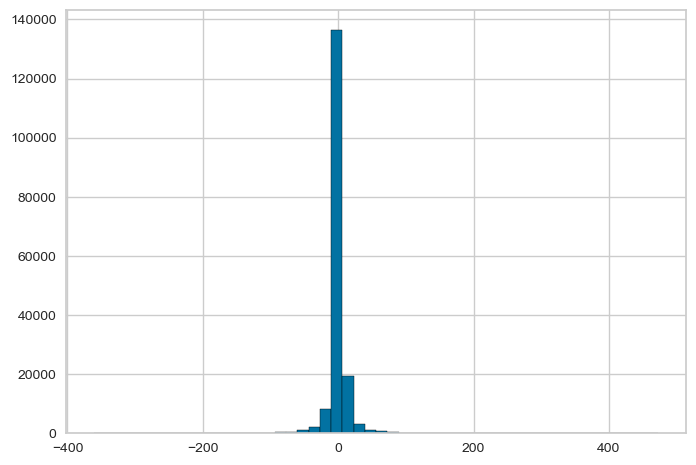

In [14]:
plt.hist(filtered_states['Ratio_Change_Bottom_Tier'], bins=50, edgecolor='black') 

#### Ratio_Change_Top_Tier

(array([6.00000e+00, 0.00000e+00, 4.00000e+00, 4.00000e+00, 4.00000e+00,
        6.00000e+00, 1.00000e+01, 1.40000e+01, 2.40000e+01, 1.80000e+01,
        2.40000e+01, 4.20000e+01, 4.80000e+01, 1.12000e+02, 1.44000e+02,
        2.40000e+02, 3.32000e+02, 7.10000e+02, 1.57200e+03, 5.32200e+03,
        1.29951e+05, 2.96660e+04, 3.23200e+03, 1.20200e+03, 5.12000e+02,
        3.20000e+02, 2.62000e+02, 1.34000e+02, 7.00000e+01, 5.40000e+01,
        3.20000e+01, 2.60000e+01, 2.40000e+01, 1.40000e+01, 1.20000e+01,
        6.00000e+00, 1.80000e+01, 6.00000e+00, 2.00000e+00, 2.00000e+00,
        2.00000e+00, 4.00000e+00, 2.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 2.00000e+00]),
 array([-314.2261702 , -299.11565437, -284.00513854, -268.89462271,
        -253.78410687, -238.67359104, -223.56307521, -208.45255938,
        -193.34204354, -178.23152771, -163.12101188, -148.01049605,
        -132.89998022, -117.78946438, -102.67894855,  -87.568432

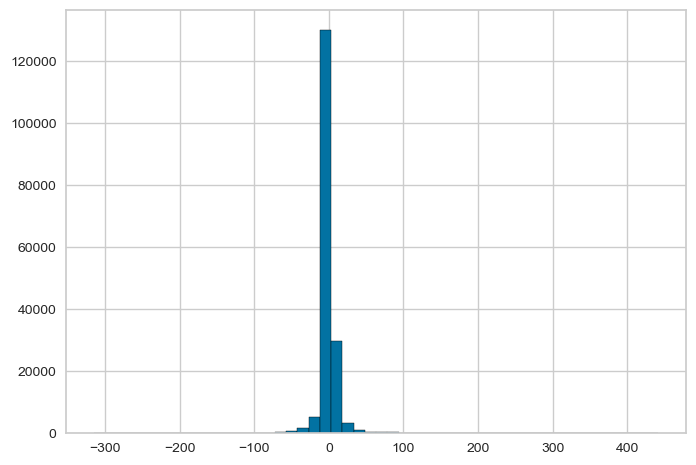

In [15]:
plt.hist(filtered_states['Ratio_Change_Top_Tier'], bins=50, edgecolor='black') 

#### Ratio_Change_Purchase_Price_Tier

(array([1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 1.1000e+01, 0.0000e+00, 1.4000e+01,
        0.0000e+00, 6.0000e+00, 2.0000e+00, 0.0000e+00, 0.0000e+00,
        9.0000e+00, 2.0000e+01, 9.0000e+00, 3.2000e+01, 4.3000e+01,
        6.6000e+01, 1.6300e+02, 4.6000e+02, 1.3870e+03, 7.1959e+04,
        9.7642e+04, 1.4880e+03, 4.7300e+02, 1.6700e+02, 7.0000e+01,
        5.2000e+01, 3.1000e+01, 1.1000e+01, 1.4000e+01, 1.0000e+01,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 1.4000e+01, 0.0000e+00,
        1.4000e+01, 0.0000e+00, 1.3000e+01, 4.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 4.0000e+00]),
 array([-1395.16129032, -1339.35483871, -1283.5483871 , -1227.74193548,
        -1171.93548387, -1116.12903226, -1060.32258065, -1004.51612903,
         -948.70967742,  -892.90322581,  -837.09677419,  -781.29032258,
         -725.48387097,  -669.67741935,  -613.87096774,  -558.06451613,
         -502.25806452,  -446.

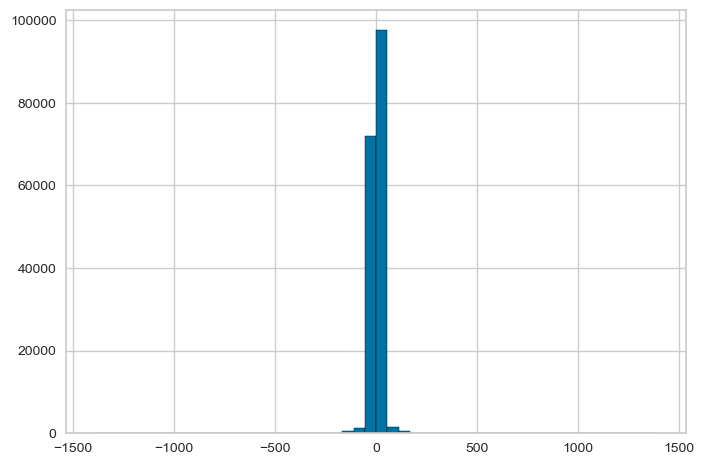

In [16]:
plt.hist(filtered_states['Ratio_Change_Purchase_Price_Tier'], bins=50, edgecolor='black') 

### Standardizing Temperature Anomaly 

In [17]:
# Create a StandardScaler object
scaler = StandardScaler()

# Column Names we want to scale
columns_to_scale = ['Anomaly (1901-2000 base period)', 'Bottom-Tier Average Home Value Estimate', 'Top-Tier Average Home Value Estimate', 'Value', 'Ratio_Change_Purchase_Price_Tier', 'Ratio_Change_Top_Tier', 'Ratio_Change_Bottom_Tier']

# Fit the scaler to the specified columns
scaler.fit(filtered_states[columns_to_scale])

#Transform Data
filtered_states[columns_to_scale] = scaler.transform(filtered_states[columns_to_scale])

# Display the first few rows of the DataFrame to check the results
filtered_states.head()

/var/folders/6c/t8_sl0r155q97klcrfwnkw7h0000gn/T/ipykernel_18984/1255592001.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_states[columns_to_scale] = scaler.transform(filtered_states[columns_to_scale])


,Unnamed: 0,Date,Year,Month,RegionName,State,Bottom-Tier Average Home Value Estimate,Top-Tier Average Home Value Estimate,Value,Anomaly (1901-2000 base period),...,AWATER,INTPTLAT,INTPTLON,geometry,Pct_Change_Bottom_Tier,Pct_Change_Top_Tier,Pct_Change,Ratio_Change_Bottom_Tier,Ratio_Change_Top_Tier,Ratio_Change_Purchase_Price_Tier
24,19022,2001-01-31,2001,1,Los Angeles County,CA,0.233583,0.279840,-0.579888,-0.673345,...,1.785003e+09,34.196398,-118.261862,"MULTIPOLYGON (((-118.67820 33.03973, -118.6756...",9.106132,8.685910,8.582949,-1.040794,-1.211113,-0.559311
25,19023,2001-01-31,2001,1,Los Angeles County,CA,0.233583,0.279840,-0.579888,-0.673345,...,1.785003e+09,34.196398,-118.261862,"MULTIPOLYGON (((-118.67820 33.03973, -118.6756...",9.106132,8.685910,13.009592,-1.040794,-1.211113,-0.836323
26,20648,2001-02-28,2001,2,Los Angeles County,CA,0.239429,0.284261,-0.591743,-1.287737,...,1.785003e+09,34.196398,-118.261862,"MULTIPOLYGON (((-118.67820 33.03973, -118.6756...",9.365314,8.909603,14.988426,-0.261568,-0.289513,-0.217610
27,20649,2001-02-28,2001,2,Los Angeles County,CA,0.239429,0.284261,-0.591743,-1.287737,...,1.785003e+09,34.196398,-118.261862,"MULTIPOLYGON (((-118.67820 33.03973, -118.6756...",9.365314,8.909603,17.348809,-0.261568,-0.289513,-0.248383
28,22276,2001-03-31,2001,3,Los Angeles County,CA,0.247852,0.290932,-0.099755,0.555440,...,1.785003e+09,34.196398,-118.261862,"MULTIPOLYGON (((-118.67820 33.03973, -118.6756...",9.478098,8.988295,17.015263,0.107317,0.144726,0.139128


#### Dropping unnecessary columns 

In [18]:
#Keeping these columns and converting to float
columns_to_float = ['ALAND', 'AWATER', 'INTPTLAT', 'INTPTLON']
filtered_states[columns_to_float] = filtered_states[columns_to_float].astype(float)

# Get column names with object data types
object_columns = filtered_states.select_dtypes(include=['object']).columns

# Drop the columns with object or geometry data types
filtered_states = filtered_states.drop(object_columns, axis=1)
filtered_states = filtered_states.drop(columns='geometry', axis=1)

/var/folders/6c/t8_sl0r155q97klcrfwnkw7h0000gn/T/ipykernel_18984/3276376471.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_states[columns_to_float] = filtered_states[columns_to_float].astype(float)


### Classifying the Ratio Changes as Low, Medium, High for Ratio_Change_Bottom_Tier and Ratio_Change_Top_Tier

In [19]:
filtered_states['Ratio_Change_Bottom_Tier'].describe()

count    1.741910e+05
mean     8.137807e-18
std      1.000003e+00
min     -1.966354e+01
25%     -1.354638e-01
50%     -1.184268e-02
75%      1.321061e-01
max      2.569029e+01
Name: Ratio_Change_Bottom_Tier, dtype: float64

In [20]:
# Calculate quartiles
quartiles = pd.qcut(filtered_states['Ratio_Change_Bottom_Tier'], q=3, labels=['low', 'medium', 'high'])

# Map quartile labels to numeric values
class_mapping = {'low': 0, 'medium': 1, 'high': 2}
filtered_states['Bottom_Tier_Class'] = quartiles.map(class_mapping)

# Display the DataFrame to check the results
filtered_states.head()

,Unnamed: 0,Year,Month,Bottom-Tier Average Home Value Estimate,Top-Tier Average Home Value Estimate,Value,Anomaly (1901-2000 base period),1901-2000 Mean,Initial Fees and Charges (%),Effective Rate (%),...,AWATER,INTPTLAT,INTPTLON,Pct_Change_Bottom_Tier,Pct_Change_Top_Tier,Pct_Change,Ratio_Change_Bottom_Tier,Ratio_Change_Top_Tier,Ratio_Change_Purchase_Price_Tier,Bottom_Tier_Class
24,19022,2001,1,0.233583,0.279840,-0.579888,-0.673345,47.8,0.57,7.69,...,1.785003e+09,34.196398,-118.261862,9.106132,8.685910,8.582949,-1.040794,-1.211113,-0.559311,0
25,19023,2001,1,0.233583,0.279840,-0.579888,-0.673345,47.8,0.63,7.40,...,1.785003e+09,34.196398,-118.261862,9.106132,8.685910,13.009592,-1.040794,-1.211113,-0.836323,0
26,20648,2001,2,0.239429,0.284261,-0.591743,-1.287737,49.5,0.53,7.23,...,1.785003e+09,34.196398,-118.261862,9.365314,8.909603,14.988426,-0.261568,-0.289513,-0.217610,0
27,20649,2001,2,0.239429,0.284261,-0.591743,-1.287737,49.5,0.61,7.22,...,1.785003e+09,34.196398,-118.261862,9.365314,8.909603,17.348809,-0.261568,-0.289513,-0.248383,0
28,22276,2001,3,0.247852,0.290932,-0.099755,0.555440,52.1,0.54,7.17,...,1.785003e+09,34.196398,-118.261862,9.478098,8.988295,17.015263,0.107317,0.144726,0.139128,2


(array([58064.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 58063.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 58064.]),
 array([0.  , 0.04, 0.08, 0.12, 0.16, 0.2 , 0.24, 0.28, 0.32, 0.36, 0.4 ,
        0.44, 0.48, 0.52, 0.56, 0.6 , 0.64, 0.68, 0.72, 0.76, 0.8 , 0.84,
        0.88, 0.92, 0.96, 1.  , 1.04, 1.08, 1.12, 1.16, 1.2 , 1.24, 1.28,
        1.32, 1.36, 1.4 , 1.44, 1.48, 1.52, 1.56, 1.6 , 1.64, 1.68, 1.72,
        1.76, 1.8 , 1.84, 1.88, 1.92, 1.96, 2.  ]),
 <BarContainer object of 50 artists>)

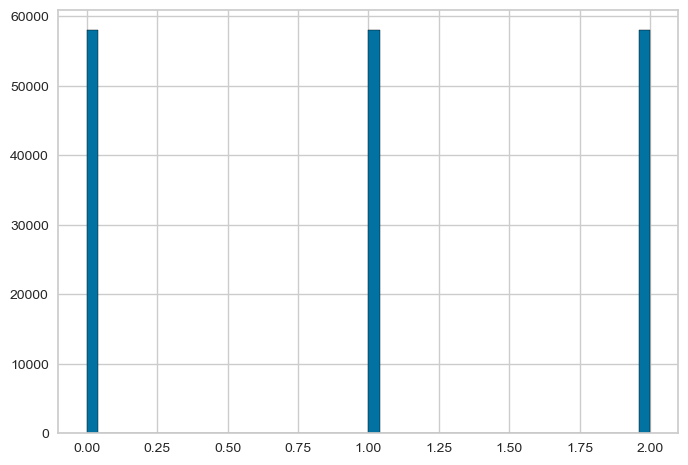

In [21]:
plt.hist(filtered_states['Bottom_Tier_Class'], bins=50, edgecolor='black') 

In [22]:
# Calculate quartiles
quartiles = pd.qcut(filtered_states['Ratio_Change_Top_Tier'], q=3, labels=['low', 'medium', 'high'])

# Map quartile labels to numeric values
class_mapping = {'low': 0, 'medium': 1, 'high': 2}
filtered_states['Top_Tier_Class'] = quartiles.map(class_mapping)

# Display the DataFrame to check the results
filtered_states.head()

,Unnamed: 0,Year,Month,Bottom-Tier Average Home Value Estimate,Top-Tier Average Home Value Estimate,Value,Anomaly (1901-2000 base period),1901-2000 Mean,Initial Fees and Charges (%),Effective Rate (%),...,INTPTLAT,INTPTLON,Pct_Change_Bottom_Tier,Pct_Change_Top_Tier,Pct_Change,Ratio_Change_Bottom_Tier,Ratio_Change_Top_Tier,Ratio_Change_Purchase_Price_Tier,Bottom_Tier_Class,Top_Tier_Class
24,19022,2001,1,0.233583,0.279840,-0.579888,-0.673345,47.8,0.57,7.69,...,34.196398,-118.261862,9.106132,8.685910,8.582949,-1.040794,-1.211113,-0.559311,0,0
25,19023,2001,1,0.233583,0.279840,-0.579888,-0.673345,47.8,0.63,7.40,...,34.196398,-118.261862,9.106132,8.685910,13.009592,-1.040794,-1.211113,-0.836323,0,0
26,20648,2001,2,0.239429,0.284261,-0.591743,-1.287737,49.5,0.53,7.23,...,34.196398,-118.261862,9.365314,8.909603,14.988426,-0.261568,-0.289513,-0.217610,0,0
27,20649,2001,2,0.239429,0.284261,-0.591743,-1.287737,49.5,0.61,7.22,...,34.196398,-118.261862,9.365314,8.909603,17.348809,-0.261568,-0.289513,-0.248383,0,0
28,22276,2001,3,0.247852,0.290932,-0.099755,0.555440,52.1,0.54,7.17,...,34.196398,-118.261862,9.478098,8.988295,17.015263,0.107317,0.144726,0.139128,2,2


(array([58064.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 58063.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 58064.]),
 array([0.  , 0.04, 0.08, 0.12, 0.16, 0.2 , 0.24, 0.28, 0.32, 0.36, 0.4 ,
        0.44, 0.48, 0.52, 0.56, 0.6 , 0.64, 0.68, 0.72, 0.76, 0.8 , 0.84,
        0.88, 0.92, 0.96, 1.  , 1.04, 1.08, 1.12, 1.16, 1.2 , 1.24, 1.28,
        1.32, 1.36, 1.4 , 1.44, 1.48, 1.52, 1.56, 1.6 , 1.64, 1.68, 1.72,
        1.76, 1.8 , 1.84, 1.88, 1.92, 1.96, 2.  ]),
 <BarContainer object of 50 artists>)

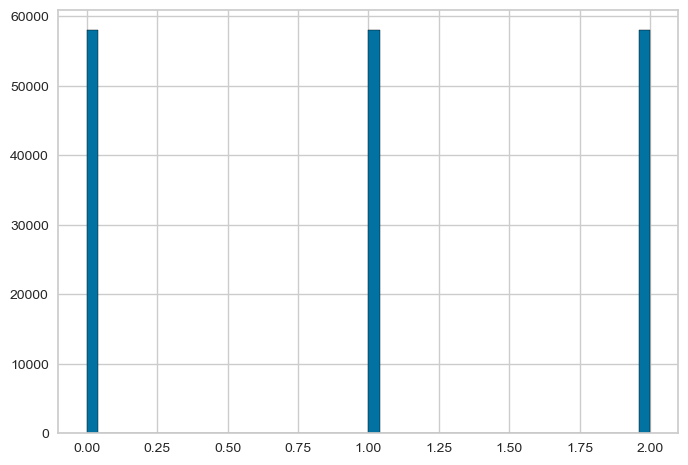

In [23]:
plt.hist(filtered_states['Top_Tier_Class'], bins=50, edgecolor='black') 

In [25]:
# Calculate quartiles
quartiles = pd.qcut(filtered_states['Ratio_Change_Purchase_Price_Tier'], q=3, labels=['low', 'medium', 'high'])

# Map quartile labels to numeric values
class_mapping = {'low': 0, 'medium': 1, 'high': 2}
filtered_states['Purchase_Price_Class'] = quartiles.map(class_mapping)

# Display the DataFrame to check the results
filtered_states.head()



,Unnamed: 0,Year,Month,Bottom-Tier Average Home Value Estimate,Top-Tier Average Home Value Estimate,Value,Anomaly (1901-2000 base period),1901-2000 Mean,Initial Fees and Charges (%),Effective Rate (%),...,INTPTLON,Pct_Change_Bottom_Tier,Pct_Change_Top_Tier,Pct_Change,Ratio_Change_Bottom_Tier,Ratio_Change_Top_Tier,Ratio_Change_Purchase_Price_Tier,Bottom_Tier_Class,Top_Tier_Class,Purchase_Price_Class
24,19022,2001,1,0.233583,0.279840,-0.579888,-0.673345,47.8,0.57,7.69,...,-118.261862,9.106132,8.685910,8.582949,-1.040794,-1.211113,-0.559311,0,0,0
25,19023,2001,1,0.233583,0.279840,-0.579888,-0.673345,47.8,0.63,7.40,...,-118.261862,9.106132,8.685910,13.009592,-1.040794,-1.211113,-0.836323,0,0,0
26,20648,2001,2,0.239429,0.284261,-0.591743,-1.287737,49.5,0.53,7.23,...,-118.261862,9.365314,8.909603,14.988426,-0.261568,-0.289513,-0.217610,0,0,0
27,20649,2001,2,0.239429,0.284261,-0.591743,-1.287737,49.5,0.61,7.22,...,-118.261862,9.365314,8.909603,17.348809,-0.261568,-0.289513,-0.248383,0,0,0
28,22276,2001,3,0.247852,0.290932,-0.099755,0.555440,52.1,0.54,7.17,...,-118.261862,9.478098,8.988295,17.015263,0.107317,0.144726,0.139128,2,2,2


(array([58069.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 58060.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 58062.]),
 array([0.  , 0.04, 0.08, 0.12, 0.16, 0.2 , 0.24, 0.28, 0.32, 0.36, 0.4 ,
        0.44, 0.48, 0.52, 0.56, 0.6 , 0.64, 0.68, 0.72, 0.76, 0.8 , 0.84,
        0.88, 0.92, 0.96, 1.  , 1.04, 1.08, 1.12, 1.16, 1.2 , 1.24, 1.28,
        1.32, 1.36, 1.4 , 1.44, 1.48, 1.52, 1.56, 1.6 , 1.64, 1.68, 1.72,
        1.76, 1.8 , 1.84, 1.88, 1.92, 1.96, 2.  ]),
 <BarContainer object of 50 artists>)

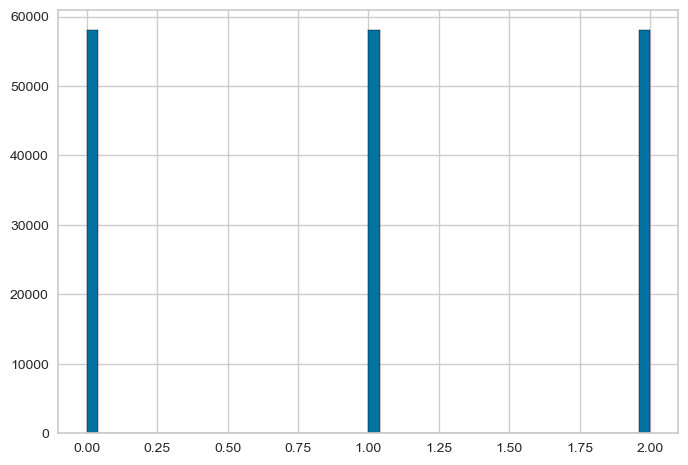

In [27]:
plt.hist(filtered_states['Purchase_Price_Class'], bins=50, edgecolor='black') 

In [31]:

pd.concat({"Number missing values":filtered_states.isnull().sum()
            , "Percentage of missing values":filtered_states.isnull().sum()*100/filtered_states.shape[0]}
            , axis=1)

,Number missing values,Percentage of missing values
Unnamed: 0,0,0.0
Year,0,0.0
Month,0,0.0
Bottom-Tier Average Home Value Estimate,0,0.0
Top-Tier Average Home Value Estimate,0,0.0
Value,0,0.0
Anomaly (1901-2000 base period),0,0.0
1901-2000 Mean,0,0.0
Initial Fees and Charges (%),0,0.0
Effective Rate (%),0,0.0


## Train/Test Splitting Data

In [38]:
#splitting the data 
seed = 7

test = filtered_states[filtered_states['Year'] == 2019]
train = filtered_states[filtered_states['Year'] != 2019]

X_train= train[train.columns.difference(['Bottom_Tier_Class'])]
X_test = test[test.columns.difference(['Bottom_Tier_Class'])]

y_train = train['Bottom_Tier_Class']
y_test = test['Bottom_Tier_Class']



## Exploring Models for Top Tier Average Home Values

1. Naive Bayes
2. Logistic Regression

### 1. Naive Bayes

[[   0 1148  164]
 [   0 1024  154]
 [   0 1534  282]]
              precision    recall  f1-score   support

         Low       0.00      0.00      0.00      1312
      Medium       0.28      0.87      0.42      1178
        High       0.47      0.16      0.23      1816

    accuracy                           0.30      4306
   macro avg       0.25      0.34      0.22      4306
weighted avg       0.27      0.30      0.21      4306



/Users/yokokentilitisca/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yokokentilitisca/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yokokentilitisca/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

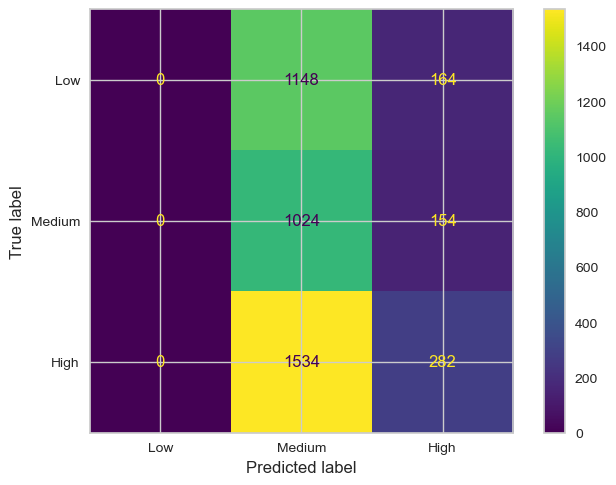

In [36]:
# your code here
modelNB = GaussianNB()

#Training the model
modelNB.fit(X_train, y_train)

#Getting predictions
y_train_pred_NB = modelNB.predict(X_train)
y_test_pred_NB = modelNB.predict(X_test)

#Print Confusion Matrix
print(confusion_matrix(y_test, y_test_pred_NB))

#Labels
labels = ['Low', 'Medium', 'High']
#Print the classification report
print(classification_report(y_test, y_test_pred_NB, target_names=labels))

cm = confusion_matrix(y_test, y_test_pred_NB)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()


### 2. Logistic Regression

[[   0    0 1312]
 [   0    0 1178]
 [   0    0 1816]]
              precision    recall  f1-score   support

         Low       0.00      0.00      0.00      1312
      Medium       0.00      0.00      0.00      1178
        High       0.42      1.00      0.59      1816

    accuracy                           0.42      4306
   macro avg       0.14      0.33      0.20      4306
weighted avg       0.18      0.42      0.25      4306



/Users/yokokentilitisca/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yokokentilitisca/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yokokentilitisca/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

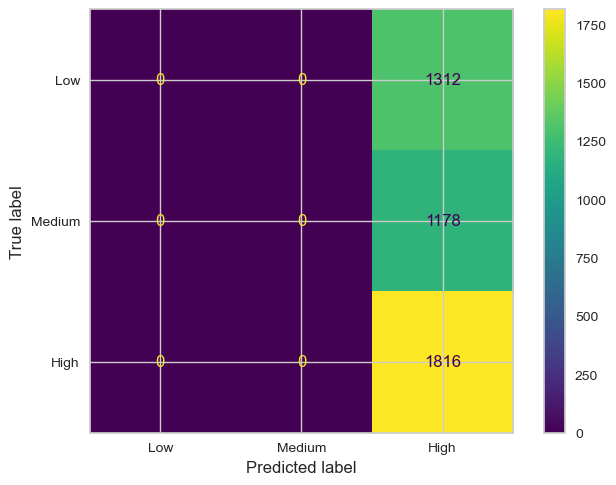

In [37]:
# your code here
model_lr = LogisticRegression(max_iter=10000)

#Fitting the model to SMOTE
model_lr.fit(X_train, y_train)

#Getting predictions
y_train_pred_lr = model_lr.predict(X_train)
y_test_pred_lr = model_lr.predict(X_test)

#Print Confusion Matrix
print(confusion_matrix(y_test, y_test_pred_lr))

#Print the classification report
print(classification_report(y_test, y_test_pred_lr, target_names=labels))

cm = confusion_matrix(y_test, y_test_pred_lr)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()

[[1312    0    0]
 [   0 1178    0]
 [   0    0 1816]]
              precision    recall  f1-score   support

         Low       1.00      1.00      1.00      1312
      Medium       1.00      1.00      1.00      1178
        High       1.00      1.00      1.00      1816

    accuracy                           1.00      4306
   macro avg       1.00      1.00      1.00      4306
weighted avg       1.00      1.00      1.00      4306



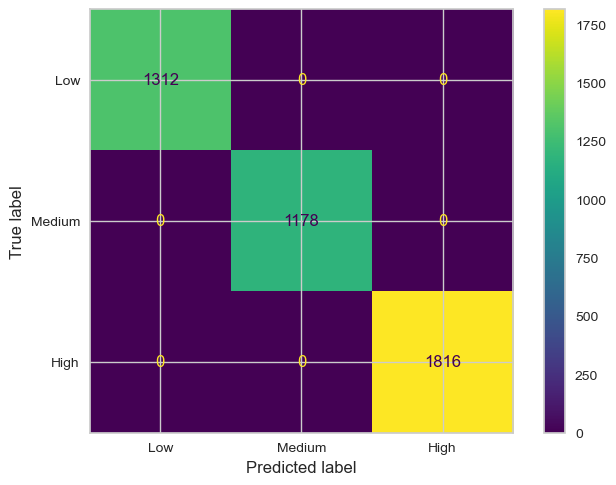

In [40]:
#your code here
model_abc = AdaBoostClassifier()

#Fit the model
model_abc.fit(X_train, y_train)

#Evaluate the model, Predictions
y_pred_train_abc = model_abc.predict(X_train)
y_pred_test_abc = model_abc.predict(X_test)

#Print Confusion Matrix
print(confusion_matrix(y_test, y_pred_test_abc ))

#Print the classification report
print(classification_report(y_test, y_pred_test_abc , target_names=labels))

cm = confusion_matrix(y_test, y_pred_test_abc )
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()

#### We will explore more with this dataset, looking at Ratio Changes (for purchase price) and Bottom Tier Average Home Values. We will adjust the classes but will use the insights of this model to look into a clustering question. Overall, the Naive Bayes model we pretty balanced with an accuracy score of 0.51. For the recall, it scored low in classifying for those ratio changes that were low from year to year, so we will be exploring more.  